# DeiT + CIFAR100

In [1]:
# Set Project Root Directory
import os

current_dir = os.getcwd()
root_marker = "common"
while current_dir != os.path.dirname(current_dir):
    if root_marker in os.listdir(current_dir):
        break
    current_dir = os.path.dirname(current_dir)

project_root = current_dir
if os.getcwd() != project_root:
    %cd {project_root};

In [2]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.v2 as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from timm.models import deit
from timm.optim import Lookahead
import lightning as L
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchinfo import summary

from common.optim.ranger import Ranger
from common.optim.sam import SAM, bypass_running_stats
from common.utils.training import evaluate
from common.loss.acls import ACLS

In [3]:
names = list()
results = defaultdict(dict)

## Architecture

In [10]:
summary(deit.deit_tiny_patch16_224(num_classes=100, img_size=(32, 32), patch_size=(4, 4)), (1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
VisionTransformer                        [1, 100]                  12,672
├─PatchEmbed: 1-1                        [1, 64, 192]              --
│    └─Conv2d: 2-1                       [1, 192, 8, 8]            9,408
│    └─Identity: 2-2                     [1, 64, 192]              --
├─Dropout: 1-2                           [1, 65, 192]              --
├─Identity: 1-3                          [1, 65, 192]              --
├─Identity: 1-4                          [1, 65, 192]              --
├─Sequential: 1-5                        [1, 65, 192]              --
│    └─Block: 2-3                        [1, 65, 192]              --
│    │    └─LayerNorm: 3-1               [1, 65, 192]              384
│    │    └─Attention: 3-2               [1, 65, 192]              148,224
│    │    └─Identity: 3-3                [1, 65, 192]              --
│    │    └─Identity: 3-4                [1, 65, 192]              --
│ 

## Train

### RA + L, OCLR, LS

In [11]:
def train_cifar100_deit_tiny_ra_l_oclr_ls(fabric):
    L.seed_everything(seed=0xcafe, workers=True, verbose=True)
    batch_size = 32
    epochs = 200
    print_interval = 10

    train_transform = transforms.Compose([
        transforms.ToImage(),
        transforms.RandomResizedCrop(size=32, antialias=True),
        transforms.RandomHorizontalFlip(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])
    train_ds = datasets.CIFAR100(
        root='./image_recognition/data',
        train=True,
        transform=train_transform,
        download=True,
    )
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
        persistent_workers=True,
    )

    n_data = len(train_ds)

    net = deit.deit_tiny_patch16_224(
        num_classes=100,
        img_size=(32, 32),
        patch_size=(4, 4),
    )
    base_optimizer = optim.RAdam(
        params=net.parameters(),
        lr=1e-4,
        weight_decay=5e-4,
        decoupled_weight_decay=True,
        foreach=True,
    )
    optimizer = Lookahead(
        base_optimizer,
        alpha=0.5,
        k=6,
    )
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=1e-3,
        steps_per_epoch=len(train_loader),
        epochs=epochs,
    )
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    model = torch.compile(net, mode='reduce-overhead')
    model, optimizer = fabric.setup(model, optimizer)
    loader = fabric.setup_dataloaders(train_loader)

    model.train()
    logs = defaultdict(list)
    for epoch in tqdm(range(epochs)):
        total_loss = 0
        for x, y in loader:
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            fabric.backward(loss)
            optimizer.step()
            scheduler.step()

            total_loss += loss.item() * len(x)

        total_loss = total_loss / n_data
        logs['loss'].append(total_loss)

        if epoch == 0 or (epoch + 1) % print_interval == 0:
            print(f"EPOCH: {epoch + 1}/{epochs}, LOSS: {total_loss:.5f}")

    torch.save(net.to('cpu').state_dict(), './image_recognition/weights/CIFAR100_DEIT_TINY_RA_L_OCLR_LS.pth')
    return dict(logs)

Using bfloat16 Automatic Mixed Precision (AMP)
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Seed set to 51966


Files already downloaded and verified


  0%|          | 0/200 [00:00<?, ?it/s]

W1011 10:55:17.152000 140455940327232 torch/fx/experimental/symbolic_shapes.py:4449] [0/1] ps1 is not in var_ranges, defaulting to unknown range.
W1011 10:55:18.853000 140455940327232 torch/fx/experimental/symbolic_shapes.py:4449] [0/1] ps1 is not in var_ranges, defaulting to unknown range.


EPOCH: 1/200, LOSS: 4.35256
EPOCH: 10/200, LOSS: 3.32435
EPOCH: 20/200, LOSS: 2.88906
EPOCH: 30/200, LOSS: 2.54611
EPOCH: 40/200, LOSS: 2.22828
EPOCH: 50/200, LOSS: 1.95240
EPOCH: 60/200, LOSS: 1.72701
EPOCH: 70/200, LOSS: 1.54929
EPOCH: 80/200, LOSS: 1.43441
EPOCH: 90/200, LOSS: 1.33232
EPOCH: 100/200, LOSS: 1.25911
EPOCH: 110/200, LOSS: 1.20714
EPOCH: 120/200, LOSS: 1.15170
EPOCH: 130/200, LOSS: 1.11554
EPOCH: 140/200, LOSS: 1.07273
EPOCH: 150/200, LOSS: 1.04279
EPOCH: 160/200, LOSS: 1.01347
EPOCH: 170/200, LOSS: 0.98418
EPOCH: 180/200, LOSS: 0.97317
EPOCH: 190/200, LOSS: 0.96284
EPOCH: 200/200, LOSS: 0.96064


/tmp/ipykernel_2655/3389566901.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()


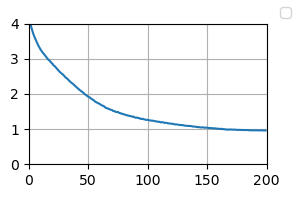

In [12]:
fabric = L.Fabric(
    accelerator='cuda',
    devices=[0],
    precision='bf16-mixed',
)
name = 'CIFAR100_DEIT_TINY_RA_L_OCLR_LS'
results[name] = fabric.launch(train_cifar100_deit_tiny_ra_l_oclr_ls)
names.append(name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 2))
ax.plot(results[name]['loss'])
ax.grid()
ax.set_ylim((0.0, 4.0))
ax.set_xlim((0, 200))
fig.tight_layout()
fig.legend()
plt.show()

### RA + L, OCLR, LS, FT

In [8]:
def train_cifar100_deit_tiny_ra_l_oclr_ls_ft(fabric):
    L.seed_everything(seed=0xcafe, workers=True, verbose=True)
    batch_size = 32
    epochs = 200
    print_interval = 10

    train_transform = transforms.Compose([
        transforms.ToImage(),
        transforms.RandomResizedCrop(size=32, antialias=True),
        transforms.RandomHorizontalFlip(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])
    train_ds = datasets.CIFAR100(
        root='./image_recognition/data',
        train=True,
        transform=train_transform,
        download=True,
    )
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
        persistent_workers=True,
    )

    n_data = len(train_ds)

    net = deit.deit_tiny_patch16_224(
        pretrained=True,
        num_classes=100,
        img_size=(32, 32),
        patch_size=(4, 4),
    )
    base_optimizer = optim.RAdam(
        params=net.parameters(),
        lr=1e-4,
        weight_decay=5e-4,
        decoupled_weight_decay=True,
        foreach=True,
    )
    optimizer = Lookahead(
        base_optimizer,
        alpha=0.5,
        k=6,
    )
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=1e-3,
        steps_per_epoch=len(train_loader),
        epochs=epochs,
    )
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    model = torch.compile(net, mode='reduce-overhead')
    model, optimizer = fabric.setup(model, optimizer)
    loader = fabric.setup_dataloaders(train_loader)

    model.train()
    logs = defaultdict(list)
    for epoch in tqdm(range(epochs)):
        total_loss = 0
        for x, y in loader:
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            fabric.backward(loss)
            optimizer.step()
            scheduler.step()

            total_loss += loss.item() * len(x)

        total_loss = total_loss / n_data
        logs['loss'].append(total_loss)

        if epoch == 0 or (epoch + 1) % print_interval == 0:
            print(f"EPOCH: {epoch + 1}/{epochs}, LOSS: {total_loss:.5f}")

    torch.save(net.to('cpu').state_dict(), './image_recognition/weights/CIFAR100_DEIT_TINY_RA_L_OCLR_LS_FT.pth')
    return dict(logs)

Using bfloat16 Automatic Mixed Precision (AMP)
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Seed set to 51966


Files already downloaded and verified


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

  0%|          | 0/200 [00:00<?, ?it/s]

W1011 12:21:13.898000 140066413393728 torch/fx/experimental/symbolic_shapes.py:4449] [0/1] ps1 is not in var_ranges, defaulting to unknown range.
W1011 12:21:15.559000 140066413393728 torch/fx/experimental/symbolic_shapes.py:4449] [0/1] ps1 is not in var_ranges, defaulting to unknown range.


EPOCH: 1/200, LOSS: 3.97465
EPOCH: 10/200, LOSS: 1.73952
EPOCH: 20/200, LOSS: 1.66347
EPOCH: 30/200, LOSS: 1.68526
EPOCH: 40/200, LOSS: 1.67334
EPOCH: 50/200, LOSS: 1.60221
EPOCH: 60/200, LOSS: 1.49436
EPOCH: 70/200, LOSS: 1.38542
EPOCH: 80/200, LOSS: 1.31166
EPOCH: 90/200, LOSS: 1.23854
EPOCH: 100/200, LOSS: 1.18656
EPOCH: 110/200, LOSS: 1.14670
EPOCH: 120/200, LOSS: 1.10244
EPOCH: 130/200, LOSS: 1.07118
EPOCH: 140/200, LOSS: 1.04125
EPOCH: 150/200, LOSS: 1.00694
EPOCH: 160/200, LOSS: 0.98316
EPOCH: 170/200, LOSS: 0.95497
EPOCH: 180/200, LOSS: 0.94845
EPOCH: 190/200, LOSS: 0.93549
EPOCH: 200/200, LOSS: 0.93553


/tmp/ipykernel_21148/3258549459.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()


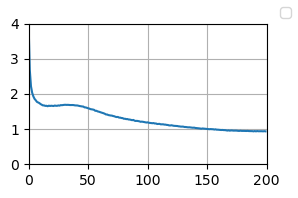

In [9]:
fabric = L.Fabric(
    accelerator='cuda',
    devices=[0],
    precision='bf16-mixed',
)
name = 'CIFAR100_DEIT_TINY_RA_L_OCLR_LS_FT'
results[name] = fabric.launch(train_cifar100_deit_tiny_ra_l_oclr_ls_ft)
names.append(name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 2))
ax.plot(results[name]['loss'])
ax.grid()
ax.set_ylim((0.0, 4.0))
ax.set_xlim((0, 200))
fig.tight_layout()
fig.legend()
plt.show()

## Eval

In [4]:
def evaluate_phase(weight_name, device):
    test_transform = transforms.Compose([
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])
    test_ds = datasets.CIFAR100(
        root='./image_recognition/data',
        train=False,
        transform=test_transform,
        download=False,
    )
    test_loader = DataLoader(
        test_ds,
        batch_size=256,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
        persistent_workers=True,
    )

    net = deit.deit_tiny_patch16_224(
        num_classes=100,
        img_size=(32, 32),
        patch_size=(4, 4),
    )
    net.load_state_dict(torch.load('./image_recognition/weights/' + weight_name, weights_only=True))
    net.to(device)

    acc = evaluate(net, test_loader, device)
    return acc

In [5]:
test_ds = datasets.CIFAR100(
    root='./image_recognition/data',
    train=False,
    download=True,
)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Files already downloaded and verified


In [10]:
# search weights
src = Path('./image_recognition/weights')
src = src.glob('CIFAR100_DEIT_TINY*.pth')
src = map(lambda p: p.stem, src)
names = list(set(names) | set(src))
del src
names

['CIFAR100_DEIT_TINY_RA_L_OCLR_LS', 'CIFAR100_DEIT_TINY_RA_L_OCLR_LS_FT']

In [11]:
for name in names:
    if not ('acc' in results[name]):
        results[name]['acc'] = evaluate_phase(name + '.pth', device=device)
    print(f'Acc: {name}, {results[name]['acc']:.5f}')

Acc: CIFAR100_DEIT_TINY_RA_L_OCLR_LS, 0.55850
Acc: CIFAR100_DEIT_TINY_RA_L_OCLR_LS_FT, 0.75060
